In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Test_Segmentation/

/content/drive/MyDrive/Colab Notebooks/Test_Segmentation


In [ ]:
!ls

classes.csv  model  prof_data  utils


In [3]:
semSegClasses = {  
     0: [0, 0, 0],         # None 
     1: [70, 70, 70],      # Buildings 
     2: [190, 153, 153],   # Fences 
     3: [72, 0, 90],       # Other 
     4: [220, 20, 60],     # Pedestrians 
     5: [153, 153, 153],   # Poles 
     6: [157, 234, 50],    # RoadLines 
     7: [128, 64, 128],    # Roads 
     8: [244, 35, 232],    # Sidewalks 
     9: [107, 142, 35],    # Vegetation 
     10: [0, 0, 255],      # Vehicles 
     11: [102, 102, 156],  # Walls 
     12: [220, 220, 0]     # TrafficSigns 
 } 

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Test_segmentation

/content/drive/MyDrive/Colab Notebooks/Test_segmentation


In [4]:
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img,array_to_img,img_to_array
import matplotlib.pyplot as plt

# Test one-hot architecture from kaggle's code style

*   List item
*   List item



In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tensorflow.keras.preprocessing.image import load_img,array_to_img,img_to_array
import skimage
import keras

In [6]:
%cd /content/drive/MyDrive/Colab Notebooks/Test_Segmentation/utils
import helpers

/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/utils


In [7]:
rgb_dir='/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/prof_data/rgb'
seg_dir='/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/prof_data/seg'

images_path = list(sorted([ os.path.join(rgb_dir, fname) for fname in os.listdir(rgb_dir) ]))
segmentations_path = list(sorted([ os.path.join(seg_dir, fname) for fname in os.listdir(seg_dir)]))

In [12]:
import random
val_samples = 200
images=[]
annotations=[]
classnames,label_values = helpers.get_label_info('/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/classes.csv')
for i in range(1237):
    img1,label_img= cv2.imread(images_path[i]),cv2.imread(segmentations_path[i])#[:,:,2]
    img1=cv2.resize(img1,(256,256))
    label_img = cv2.cvtColor(label_img,cv2.COLOR_BGR2RGB)
    # label_img = img_to_array(label_img)
    mask1 = np.float32(helpers.one_hot_it(label_img,label_values))
    mask1 = helpers.reverse_one_hot(mask1)
   
    # mask1 = helpers.colour_code_segmentation(mask1,label_values)
    mask1 = mask1.astype('float32')
    mask1 = cv2.resize(mask1,(256,256,))
    images.append(img1)
    annotations.append(mask1)
images=np.array(images)
annotations=np.array(annotations)

In [15]:
def plotter(img,mask):
    fig,axes=plt.subplots(1,2)
    axes[0].imshow(img)
    plt.imshow(mask)

In [ ]:
# test_ano = annotations
# test_ano = np.array(test_ano)
# plt.subplot(1,2,1)
# plt.imshow(np.expand_dims(annotations[4], axis=0))
# plt.subplot(1,2,2)
# plt.imshow(test_ano[4])

In [13]:
len(images)

1237

[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [7. 7. 7. ... 7. 7. 7.]
 [7. 7. 7. ... 7. 7. 7.]
 [7. 7. 7. ... 7. 7. 7.]]


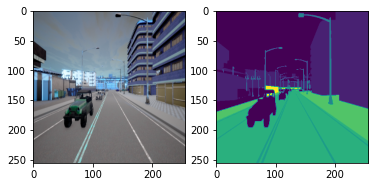

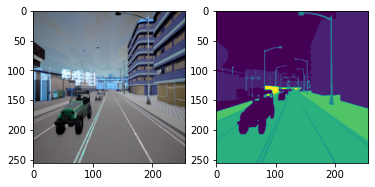

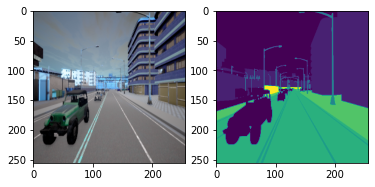

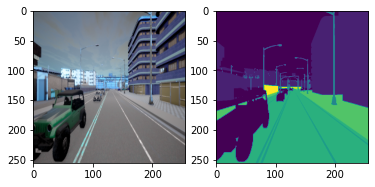

In [16]:
for i in range(1,5):
    plotter(images[i],annotations[i])
print(annotations[1])

In [18]:
random.Random(1237).shuffle(images)
random.Random(1237).shuffle(annotations)
train_data=images[:-val_samples]
train_annotate=annotations[:-val_samples]
valid_data=images[-val_samples:]
valid_annotate=annotations[-val_samples:]

In [19]:
train_data.shape, train_annotate.shape

((1037, 256, 256, 3), (1037, 256, 256))

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dropout,MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Sequential


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model



In [ ]:
keras.backend.clear_session()
model = get_model((256,256), 13)

def scheduler(epoch, lr):
    if epoch < 10:
      return lr
    else:
      return lr * math.exp(-0.1)


model.summary()
# model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy",   metrics="accuracy")

model.compile(
  optimizer='Adam',
  loss='sparse_categorical_crossentropy',
  metrics=[tf.keras.metrics.MeanIoU(num_classes=12)])
callbacks = [
    keras.callbacks.ModelCheckpoint("test_prof_data.h5", save_best_only=True),
    keras.callbacks.LearningRateScheduler(scheduler),
]


model.fit(images, annotations, epochs=5)
callbacks = [
    keras.callbacks.ModelCheckpoint("test_prof_data.h5", save_best_only=True),
]
model.save('/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/model/model_tf',save_format='tf')
epochs = 10

NameError: ignored

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
keras.backend.clear_session()
model = get_model((256,256), 13)
model.summary()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("test_prof_data.h5", save_best_only=True),
]
model.save('/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/model/model_tf',save_format='tf')
epochs = 10

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
history=model.fit(images,annotations,batch_size=32, epochs = 50 ,callbacks=callbacks,validation_split=0.2)



```
`# This is formatted as code`
```

Retrain from the last weights

In [ ]:
test_loss = model.evaluate(images, annotations)


39/39 [==============================] - 6s 141ms/step - loss: 0.1516 - accuracy: 0.9414


In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/model/model_tf')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

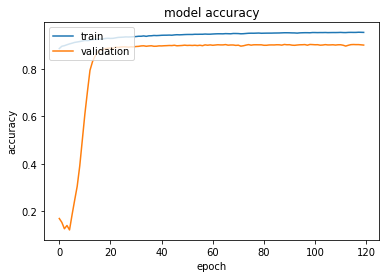

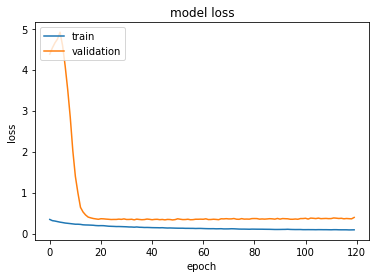

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# loading the saved model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/model/model_tf')
callbacks_retrain = [
    keras.callbacks.ModelCheckpoint("test_prof_data_retrain.h5", save_best_only=True),
]
# retraining the model
loaded_model.fit(images, annotations, batch_size=32,epochs = 50,callbacks=callbacks_retrain,  validation_split=0.2)

In [ ]:
images.shape, annotations.shape

((1237, 256, 256, 3), (1237, 256, 256))

In [9]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/utils/test_prof_data.h5')

In [ ]:
path_test = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/dataA/82.jpg'
img_test = cv2.imread(path_test)
img_test = cv2.resize(img_test,(256,256,))
plt.imshow(img_test)

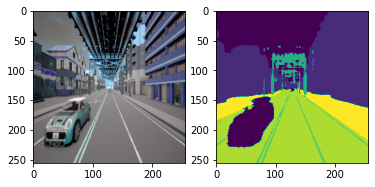

In [20]:
number = 100
test = images[number]
getshape=test.shape
pred = model.predict(test.reshape(1,getshape[0],getshape[1],getshape[2]))

#print(pred.shape)        
newimg = np.zeros((256,256))
#print(pred)
for i in range(13):
    for j in range(256):
        for k in range(256):
            if pred[0,j,k,i] > 0.4:
                newimg[j,k] = i
# newimg = helpers.colour_code_segmentation(newimg,label_values)
plotter(test,newimg)

In [21]:
print(newimg)

[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [7. 7. 7. ... 7. 7. 7.]
 [7. 7. 7. ... 7. 7. 7.]
 [7. 7. 7. ... 7. 7. 7.]]


# Test one hot encoding

In [ ]:
path_label_img = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data/seg/03.png'
path_img = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data/rgb/03.jpg'
classnames,label_values = helpers.get_label_info('/content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/CamVid/classes.csv')

In [ ]:
print(len(label_values))

13


In [ ]:
img1,label_img= cv2.imread(path_img),cv2.imread(path_label_img)
label_img = cv2.cvtColor(label_img,cv2.COLOR_BGR2RGB)

[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [7. 7. 7. ... 7. 7. 7.]
 [7. 7. 7. ... 7. 7. 7.]
 [7. 7. 7. ... 7. 7. 7.]]


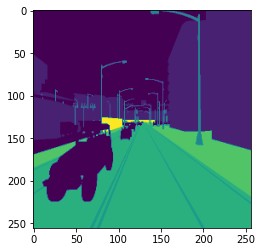

In [ ]:
# label_img = img_to_array(label_img)
mask = helpers.one_hot_it(label_img,label_values)
mask = helpers.reverse_one_hot(mask)
# #mask = cv2.resize(mask,(256,256))
# mask = helpers.colour_code_segmentation(mask,label_values)
mask = mask.astype('float32')
mask = cv2.resize(mask,(256,256,))
# plt.imshow(mask)
# mask.shape
# mask = np.array(mask)
print(mask)
plt.imshow(mask)

In [ ]:
def mask_to_onehot(mask, palette):
    """
    Converts a segmentation mask (H, W, C) to (H, W, K) where the last dim is a one
    hot encoding vector, C is usually 1 or 3, and K is the number of class.
    """
    semantic_map = []
    for colour in palette:
        equality = np.equal(mask, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    return semantic_map
    
def onehot_to_mask(mask, palette):
    """
    Converts a mask (H, W, K) to (H, W, C)
    """
    x = np.argmax(mask, axis=-1)
    colour_codes = np.array(palette)
    x = np.uint8(colour_codes[x.astype(np.uint8)])
    return x

In [ ]:
from skimage.transform import resize

mask2 = helpers.reverse_one_hot(mask2)
mask2 = resize(mask2,(256,256,))
plt.imshow(mask2)
mask2.shape

(256, 256)



```
# Định dạng của đoạn này là mã
```

# Test semantic segment from github

In [ ]:
classnames,label_values = helpers.get_label_info('/content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/CamVid/class_dict.csv')
path_img_git = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/CamVid/train/0001TP_006690.png'
path_label_img =  '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/CamVid/train_labels/0001TP_006690_L.png'
img_git,label_img_git= cv2.imread(path_img),cv2.imread(path_label_img,-1)#[:,:,2]
label_img = cv2.cvtColor(label_img,cv2.COLOR_BGR2RGB)

In [ ]:
# mask_git = np.float32(mask_git)/255.0
mask_git = np.float32(helpers.one_hot_it(label_img_git,label_values))
# mask_git = helpers.reverse_one_hot(mask_git)
# mask_git = helpers.colour_code_segmentation(mask_git,label_values)
# print(label_img_git)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 1. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 1. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 1. 0.]]]


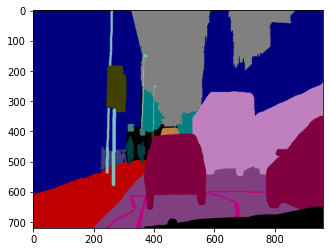

In [ ]:
print(mask_git)
plt.imshow(label_img_git)

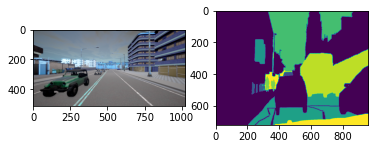

In [ ]:
plt.subplot(1,2,1)
plt.imshow(img_git)
plt.subplot(1,2,2)
plt.imshow(mask_git)

In [ ]:
test_seg = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/dataA/seg/02_00_000.png'

[[ 1  1  1 ...  0  0  0]
 [ 1  1  1 ...  0  0  0]
 [ 1  1  1 ...  0  0  0]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


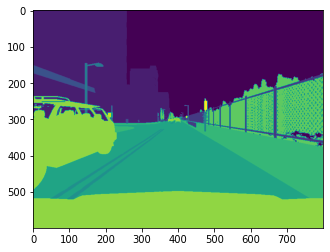

In [ ]:
seg_test = cv2.imread(test_seg)[:,:,2]
print(seg_test)
plt.imshow(seg_test)

In [ ]:
# from tensorflow.keras import layers
# import tensorflow as tf
# from tensorflow.keras.layers import Conv2D,Dropout,MaxPooling2D, Conv2DTranspose, concatenate
# from tensorflow.keras.models import Sequential

# def get_model(img_size, num_classes):
#     inputs = keras.Input(shape=img_size + (3,))

#     c1=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(inputs)
#     c1=Dropout(0.1)(c1)
#     c1=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
#     p1=MaxPooling2D(2,2)(c1)

#     c2=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(p1)
#     c2=Dropout(0.1)(c2)
#     c2=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(c2)
#     p2=MaxPooling2D(2,2)(c2)

#     c3=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(p2)
#     c3=Dropout(0.1)(c3)
#     c3=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(c3)
#     p3=MaxPooling2D(2,2)(c3)

#     c4=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(p3)
#     c4=Dropout(0.1)(c4)
#     c4=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(c4)
#     p4=MaxPooling2D(2,2)(c4)

#     c5=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(p4)
#     c5=Dropout(0.2)(c5)
#     c5=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(c5)
#     #p1=MaxPooling2D(2,2)(c1)


#     #Expansive path
#     u6=Conv2DTranspose(128,(3,3),activation='relu',strides=(2,2),kernel_initializer='he_normal', padding='same')(c5)
#     u6=concatenate([u6,c4])
#     c6=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(u6)
#     c6=Dropout(0.2)(c6)
#     c6=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(c6)

#     u7=Conv2DTranspose(64,(3,3),activation='relu',strides=(2,2),kernel_initializer='he_normal', padding='same')(c6)
#     u7=concatenate([u7,c3])
#     c7=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(u7)
#     c7=Dropout(0.2)(c7)
#     c7=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(c7)

#     u8=Conv2DTranspose(32,(3,3),activation='relu',strides=(2,2),kernel_initializer='he_normal', padding='same')(c7)
#     u8=concatenate([u8,c2])
#     c8=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(u8)
#     c8=Dropout(0.1)(c8)
#     c8=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal' ,padding='same')(c8)

#     u9=Conv2DTranspose(16,(3,3),activation='relu',strides=(2,2),kernel_initializer='he_normal', padding='same')(c8)
#     u9=concatenate([u9,c1])
#     c9=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(u9)
#     c9=Dropout(0.1)(c9)
#     c9=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(c9)


    
#     outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(c9)

#     model = keras.Model(inputs, outputs)
#     return model